In [1]:
%load_ext autoreload
%autoreload 2

**Note:** This notebook requires high RAM if you are to run headless. To remain low memory, delete some data (such as don't use a new variable everytime you take a subset of data, for no repetition, etc). 

This VM runs on Azure STANDARD_NC6 instance (or equivalent).
- CPU: 6 cores
- RAM: 56 GB. 
- GPU: 1 K80.

In [2]:
from sklearn.datasets import fetch_20newsgroups
all_xs, all_y = fetch_20newsgroups(subset="all", remove=('headers', 'footers', 'quotes'),
                    shuffle=True, return_X_y=True)

In [3]:
def split_data(data, idx=None):
    """Split data for easier visualization. NOT FOR TRAINING."""
    if idx is not None: x = data[idx].split("\n")
    else: x = data.split("\n")
    x = list(filter(lambda a: a != '', x))
    return x

In [4]:
from fastai.text.all import *

There are a few cleanings we'll have to do. Normally, we need to lower all characters, but based on what one learns in fastai, there are things that trains better with capital letters. And when we pass through fastai tokenizer, it will lower it for us, and adding a `xxmaj` for us just before this. We'll discuss about this `xxmaj` later when we came to it. 

In [5]:
# Make sure to lower all characters. 
# all_xs = [g.lower() for g in all_xs]

assert len(all_xs) == len(all_y) == 18846

This step is optional. We can either use the whole dataset, or we choose a subset. Here, to speed up training, I use a subset. However, you could just tune this value to get the best results, or just use the whole dataset. 

The idea is this: it's not necessary all short sentence gives good results. So we only keep the longer articles and discard those that are one or two sentence long (about threshold=5). Here we did it for larger threshold to speed up training, but could be tuned again for better results. 

In [6]:
def threshold_subset(all_xs, threshold=10):
    """
    Will return a numpy array containing all the data that is to be kept.
    Threshold means the number of lines (after separated using `split_data`)
    for the data to be retained, inclusive. By default, threshold=10 means
    if data is less than 10 lines it will be discarded. 
    """
    to_keep = []
    for k, x in enumerate(all_xs):
        sentence_len = len(split_data(x))
        if sentence_len >= threshold: to_keep.append(k)

    return np.array(to_keep)

In [7]:
def line_threshold(xs, y, threshold):
    """
    Give a threshold, check for assertions, and return corresponding data.
    """
    to_keep = threshold_subset(all_xs, threshold)
    np.save(f"to_keep_{threshold}", to_keep)

    assert len(to_keep) == len(np.unique(to_keep))

    return np.array(all_xs)[to_keep], np.array(all_y)[to_keep]

In [8]:
new_xs, new_y = line_threshold(all_xs, all_y, 0)

What we need to note for the `dls` functio below is that, we take in the **column name** from the `TextBlock.from_df` first arg, while the `get_x=ColReader("text")` is always fixed with "text" because the output from `TextBlock.from_df` is a pandas Series with a column named "text". If you confused with it and changed it, it'll not work. 

In [9]:
import gc
def clear_cache(del_learn_dls=False):
    if del_learn_dls:
        try:
            global learn, dls
            del learn, dls
        except Exception: pass
    gc.collect()
    torch.cuda.empty_cache()

In [10]:
clear_cache()  # assert that it works without defining learn and dls. 

In [11]:
def numpy_to_pd_to_dls(xs, y, seq_len=72, bs=32, num_workers=0, **kwargs):
    """
    Take xs and y as numpy array, convert it to pandas dataframe, 
    and make a dataloader from it. 

    :return: fastai DataLoaders. 
    """
    df = pd.DataFrame([xs, y]).T
    df.columns = ["text_", "category"]

    dls = DataBlock(
        blocks=(TextBlock.from_df("text_", seq_len=seq_len, tok=SpacyTokenizer("en")),
                CategoryBlock),
        get_x=ColReader("text"), get_y=ColReader("category"),
        splitter=RandomSplitter(0.1)
    ).dataloaders(df, bs=bs, num_workers=num_workers, seq_len=seq_len, **kwargs)

    return dls

We want to know a baseline. Now we could make a baseline. 

In [12]:
dls = numpy_to_pd_to_dls(new_xs, new_y)
dls.show_batch(max_n=2)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj try this one on for size . xxmaj i 'd rather not post her name , but if you \n email me , xxmaj i 'll tell you who she is . xxmaj enjoy ! \n\n begin 640 xxunk \n xxup xxunk # ! ! 0 ( , ! xxunk ! +8 [ p ( xxunk \n xxup xxunk # xxunk \ # xxup xxunk ] xxunk [ # xxup xxunk \ xxup i8 \n xxup xxunk - xxunk # ; xxunk : xxunk xxrep 3 ( xxunk \n m \ < / xxup xxunk \ _ xxunk < xxunk / % \ _ / e \ xxup xxunk ? # xxunk \n xxup m3 = xxunk & / $ _ & , xxunk / + xxunk ( xxrep 3 g % r. / [ ] xxunk \ \ xxunk \ \n xxup xxunk / , xxunk =",2
1,"xxbos xxrep 12 - xxmaj part 2 of 14 xxrep 12 - \n xxup m0 . / xxup xxunk / xxup cbn / xxup xxunk / xxup xxunk , xxunk , n- [ \n xxup xxunk \ _ -8 \n xxup my _ / xxup sys * / xxup xxunk \ xxup xxunk > / xxup c^ > / xxup cx_s \ xxup xxunk _ / xxup sc _ . / xxup xxunk _ . / xxup c _ / xxup gcx^ / xxup y _ . / \n m \ xxup x_scx^ / \ _ . / xxup c _ / s \ _ . / \ xxup x^ / \ xxup x^ / xxup cx_scx^ / xxup c _ . / xxup cx^ / \ xxup x^ / xxup c _ . / xxup cx^ / xxup cx^ / \n m \ xxup xxunk _ . / \",2


In [13]:
def get_learner(dls):
    return text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()],
                wd=0.1, drop_mult=0.3, pretrained=True).to_fp16()

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.001737800776027143)

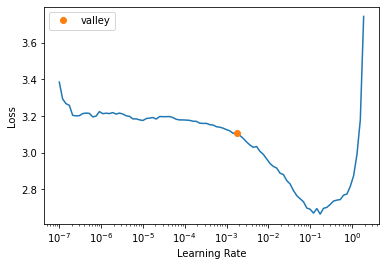

In [14]:
learn = get_learner(dls)
learn.lr_find()

In [15]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.900342,1.821486,0.414013,6.181037,06:44
1,1.927652,1.685858,0.488854,5.397079,06:45
2,1.694308,1.541702,0.528662,4.672538,06:44


In [16]:
clear_cache(True)

In [17]:
new_xs, new_y = line_threshold(all_xs, all_y, 7)
dls = numpy_to_pd_to_dls(new_xs, new_y)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0020892962347716093)

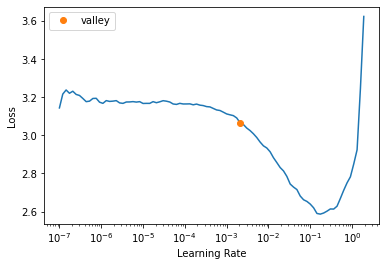

In [18]:
learn = get_learner(dls)
learn.lr_find()

In [19]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.568860,1.305940,0.570823,3.691157,05:56
1,1.395447,1.193493,0.601357,3.298582,05:54
2,1.273953,1.067229,0.662426,2.907312,05:54


Next, we want to use regex to clean some unwanted data. Perhaps we could leave the newline attached, or change it into space if it's not that important. This could be tuned. However, other things we might consider removing them that doesn't really contribute directly to training, such as line separator. 

Here the cleaning is included for some symbols that one sees manually. It's unknown whether there are additional symbols that're present that we don't want to delete. Note we use "delete" (re.sub) rather than "keep" (re.match, etc). They have their own advantage: 
- If we use "keep": we keep what we want. What we're unsure is whether there are things that we want to keep but we aren't aware of. 
- If we use "delete": we delete only what we see. What we aren't sure is whether there are things we want to delete but we aren't aware of. 

So they have their own advantage and their disadvantages. Choose as you please. 

In [20]:
import re

def clean_data(text, include_newline=True):
    text = re.sub("[<>\t]", " ", text)
    text = re.sub(r'[A-Za-z0-9]+@[A-Za-z0-9.]+', text)  # replace away emails.
    if include_newline: text = re.sub("\n", " ", text)

    # This may not require? 
    text = text.split("\'")  # .replace("\\", "") doesn't work. 
    text = "'".join(text)
    return text

In [21]:
from tqdm.notebook import tqdm

new_xs_subbed = np.array([clean_data(x, False) for x in tqdm(new_xs)])
# new_y is unchanged. 

  0%|          | 0/11794 [00:00<?, ?it/s]

In [22]:
dls = numpy_to_pd_to_dls(new_xs, new_y)
dls.show_batch(max_n=2)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj try this one on for size . xxmaj i 'd rather not post her name , but if you \n email me , xxmaj i 'll tell you who she is . xxmaj enjoy ! \n\n begin 640 xxunk \n xxup xxunk # ! ! 0 ( , ! xxunk ! +8 [ p ( xxunk \n xxup xxunk # xxunk \ # xxup xxunk ] xxunk [ # xxup xxunk \ xxup i8 \n xxup xxunk - xxunk # ; xxunk : xxunk xxrep 3 ( xxunk \n m \ < / xxup xxunk \ _ xxunk < xxunk / % \ _ / e \ xxup xxunk ? # xxunk \n xxup m3 = xxunk & / $ _ & , xxunk / + xxunk ( xxrep 3 g % r. / [ ] xxunk \ \ xxunk \ \n xxup xxunk / , xxunk =",2
1,"xxbos xxrep 12 - xxmaj part 2 of 14 xxrep 12 - \n xxup m0 . / xxup xxunk / xxup cbn / xxup xxunk / xxup xxunk , xxunk , n- [ \n xxup xxunk \ _ -8 \n xxup my _ / xxup sys * / xxup xxunk \ xxup xxunk > / xxup c^ > / xxup cx_s \ xxup xxunk _ / xxup sc _ . / xxup xxunk _ . / xxup c _ / xxup gcx^ / xxup y _ . / \n m \ xxup x_scx^ / \ _ . / xxup c _ / s \ _ . / \ xxup x^ / \ xxup x^ / xxup cx_scx^ / xxup c _ . / xxup cx^ / \ xxup x^ / xxup c _ . / xxup cx^ / xxup cx^ / \n m \ xxup xxunk _ . / \",2


Actually, we haven't finish cleaning. The reason we make the `DataLoaders` first is we want to know more about the data itself. What are the data after we tokenize it using `SpacyTokenizer`? Some data have lots of `xxunk` (meanings these words aren't available in the dictionary, for whatever reasons like count less than the threshold to put into dictionary, or dictionary already reached max word (60000) specified by `SpacyTokenizer` (default value, can be changed), or other reasons) hence they're not useful. We want to delete these. With this, we can access the tokenizer using `dls.tok`, creating a tokenized text, and from there we can delete those unwanted text. We can also set a `threshold` for deletion. In this case, we use 0.3 for the moment (can be tuned further. 0.3 is just a primitive guess). 

Extra note: you see some other tokenization in the data. E.g. of those that are often seen: (The `xx` is just a signifier, while those characters behind it is the meaning):
- `xxbos`: **b**eginning **o**f **s**entence. 
- `xxeos`: end of sentence. 
- `xxpad`: padding. 
- `xxmaj`: capital letter present in the next word. 

In [23]:
L(dls.vocab[0])

(#40184) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','\n'...]

`L` is a fastai's object. We pass through it because it has the ability to not print everything (unlike Python's list which does that and it's annoying). 

Now, we want to do something we called `stoi` (string to int). We know that the data are arranged such that the position of the vocab corresponds to the actual tokenization. See that in the code below for an example. (`itos` means int to string). 

In [24]:
def itos(vocab, word, join=False, ignore_pad=False): 
    import fastai
    if not isinstance(vocab, np.ndarray): vocab = np.array(vocab)
    if type(word) in [tuple, fastai.text.data.TensorText]: 
        word = np.array(word)
    word = vocab[word]
    if ignore_pad: word = word[word != "xxpad"]
    if join: return " ".join(word)

    return word

In [25]:
example_partial_sentence = dls.train_ds[0][0][:100]
example_partial_sentence, itos(dls.vocab[0], example_partial_sentence, True)

(TensorText([    2,    18,  1703,    94,    14,   120,    32,    74,   208,   909,
            13,    33,  2114,    15,    18,    50,    47,     9,   117,    52,
            28,    49,   762,    46,    36,    51,    12,    18,    37,   230,
           435,    14,   198,    23,     9,   107,    13,   682,   184,    20,
            11,   444,  2460,     0,    23,   107,    16,   182,     9,    59,
            66,    39,     8, 10143,     8,  4152,    12,     8,    53,   128,
            14,   387,    23,    31,   123,    47,     9,   117,    71,    31,
            93,   402,    15,  1939,   118,    13,   699,    11,   182,    12,
             9,     8,    51,    28,  7279,    43,    31,   123,    47,   290,
           110,   147,    14,    16,  1017,    13,   699,     9,   215,    59]),
 "xxbos i ran out of time on my last reply to this string and i do n't \n know if it was sent or not but . i have never heard of anyone that \n had to return something in the 30 grace xxunk that had a pro

In [26]:
new_vocab = {key: index for index, key in enumerate(dls.vocab[0])}

In [27]:
new_vocab["xxunk"]

0

But if we use stoi to convert it back, we requires to use `np.where` with each single word, which is very slow. Instead, a key-value dictionary pair speeds up searching, so we need to convert our vocab to such type first (inside our `stoi` for general function). 

In [28]:
def stoi(vocab, word):
    """
    If single word, we will convert it to list. 
    If not single word str, it will make it a list. 
    Then we want the type to be correct, else we raise error. 
    """
    import fastcore

    # Convert array to dict for vocab, if it is
    if type(vocab) in [np.ndarray, list, fastcore.foundation.L]:
        vocab = {key: index for index, key in enumerate(vocab)}

    # type checks and do stoi. 
    if isinstance(word, str): word = word.split(" ")  # convert to list
    if type(word) in [list, tuple, np.ndarray, fastcore.foundation.L]:
        m = np.zeros((len(word), )).astype(np.uint8)
        for k in range(len(word)):
            try: m[k] = vocab[word[k]]
            except KeyError: m[k] = 0  # xxunk assigned, word not in dict. 
        return m
    else: raise NotImplementedError(f"{type(word)} not implemented")

In [29]:
%timeit stoi(new_vocab, "xxunk")

2.03 µs ± 9.52 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Now we can think about creating a tokenized df. WE have a function in fastai for this, where we can pass in the df to tokenize, and the column, and then the tokenizer `dls.tok`. 

In [30]:
df_new_subbed = pd.DataFrame([new_xs_subbed, new_y]).T
df_new_subbed.columns = ["text", "category"]

df_new_toked = tokenize_df(df_new_subbed, "text", n_workers=os.cpu_count(),
                    tok=dls.tok)[0]

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


We take number 0 output, which is the pandas DataFrame we want. Number 1 output is the Counter which contains how many total counts for each occurrence of words, which we don't need. 

In [31]:
df_new_toked.head(2)

,category,text,text_length
0,10,"[xxbos, i, am, sure, some, bashers, of, xxmaj, pens, fans, are, pretty, confused, about, the, lack, \n, of, any, kind, of, posts, about, the, recent, xxmaj, pens, massacre, of, the, xxmaj, devils, ., xxmaj, actually, ,, \n, i, am, bit, puzzled, too, and, a, bit, relieved, ., xxmaj, however, ,, i, am, going, to, put, an, end, \n, to, non, -, pittsburghers, ', relief, with, a, bit, of, praise, for, the, xxmaj, pens, ., xxmaj, man, ,, they, \n, are, killing, those, xxmaj, devils, worse, than, i, thought, ., xxmaj, jagr, just, showed, you, why, \n, he, is, much, better, ...]",179
1,3,"[xxbos, xxmaj, my, brother, is, in, the, market, for, a, high, -, performance, video, card, that, supports, \n, xxup, vesa, local, bus, with, 1, -, 2, mb, xxup, ram, ., xxmaj, does, anyone, have, suggestions, /, ideas, on, :, \n\n▁, -, xxmaj, diamond, xxmaj, stealth, xxmaj, pro, xxmaj, local, xxmaj, bus, \n\n▁, -, xxmaj, orchid, xxmaj, farenheit, 1280, \n\n▁, -, xxup, ati, xxmaj, graphics, xxmaj, ultra, xxmaj, pro, \n\n▁, -, xxmaj, any, other, high, -, performance, xxup, vlb, card, \n\n\n, xxmaj, please, post, or, email, ., xxmaj, thank, you, !, \n\n▁, -, xxmaj, matt]",94


Note that here we even have `text_length` which could be used instead to threshold the number of words we want for our sentence. However, this length includes all the special tokens (that starts with `xx`), but you can still use it as threshold irregardless, if you want to. We won't be doing that here. 

In [32]:
choice = np.zeros((len(df_new_toked), )).astype(np.float32)
loop_over = df_new_toked["text"].to_numpy()

for k, data in enumerate(tqdm(loop_over)):
    g = stoi(new_vocab, data)
    choice[k] = (g == 0).sum() / len(g)

  0%|          | 0/11794 [00:00<?, ?it/s]

Actually before we use the dictionary, this thing takes more than 5 minutes to complete just to tokenize. Now looks how long it takes! 

In [33]:
(choice >= 0.3).sum()   # Threshold 30% xxunk have 15 occurrences.

6

Let's look at one of these. 

In [34]:
df_new_subbed[choice >= 0.3]

,text,category
1723,From: Center for Policy Research cpr\nSubject: Poem by Erich Fried \n\n\nPoem by German-Jewish poet Erich Fried (Holocaust survivor)\n\nEin Jude an die zionistischen Kaempfer - 1988\n\n von Erich Fried\n\nWas wollt ihr eigentlich ? Wollt ihr wirklich die uebertreffen\ndie euch niedergetreten haben vor einem Menschenalter in euer\neigenes Blut und in euren eigenen Kot ?\n\n \n\nWollt ihr die alten Foltern jetzt an andere weitergeben mit allen\nblutigen dreckigen Einzelheiten mit allem brutalen Genuss die\nFolterknechte wie unsere Vaeter sie damals erlitten haben ?\n\n \n\nWollt je...,17
5431,Here is the price list for the week April 6 to April 12.\n\n- Andrew\n\nBuySellPtsTeamPlayer\n157.5141.8150PITMario_Lemieux\n152.1136.9143BUFPat_LaFontaine\n139.3125.4131BOSAdam_Oates\n133.8120.4129DETSteve_Yzerman\n132.9119.6125WPGTeemu_Selanne\n132.9119.6125TORDoug_Gilmour\n130.9117.8120NYIPierre_Turgeon\n129.7116.7122BUFAlexander_Mogilny\n126.0113.4117PHIMark_Recchi\n120.2108.2113LALuc_Robitaille\n115.9104.3109QUEMats_Sundin\n111.3100.2106PITKevin_Stevens\n108.597.7102STLCraig_Janney\n108.597.7102VANPavel_Bure\n106.395.7100CHIJeremy_Roenick\n105.394.899QUEJoe_Sakic\n104.093.699PITRick_T...,10
8270,Here is the price list for the week April 13 to April 19.\n\n- Andrew\n\nBuySellPtsTeamPlayer\n158.9143.0157PITMario_Lemieux\n148.5133.7145BUFPat_LaFontaine\n142.7128.4141BOSAdam_Oates\n137.6123.8136DETSteve_Yzerman\n132.1118.9129WPGTeemu_Selanne\n131.7118.5127NYIPierre_Turgeon\n130.1117.1127TORDoug_Gilmour\n126.0113.4123BUFAlexander_Mogilny\n123.4111.1119PHIMark_Recchi\n121.9109.7119LALuc_Robitaille\n113.3102.0112QUEMats_Sundin\n111.3100.2110PITKevin_Stevens\n110.699.5108VANPavel_Bure\n108.697.7106STLCraig_Janney\n108.397.5107PITRick_Tocchet\n107.696.8105CHIJeremy_Roenick\n105.394.8104QUE...,10
8348,Here are the final point totals for players chosen in the USENET Hockey Draft.\nNote that only 114 players scored more than 55 points (the minimum cost)\nalthough 254 different players were chosen.\n\n- Andrew\n\nPointsTeamPlayer\n160PITMario_Lemieux\n148BUFPat_LaFontaine\n142BOSAdam_Oates\n137DETSteve_Yzerman\n132WPGTeemu_Selanne\n132NYIPierre_Turgeon\n127BUFAlexander_Mogilny\n127TORDoug_Gilmour\n125LALuc_Robitaille\n123PHIMark_Recchi\n114QUEMats_Sundin\n111PITKevin_Stevens\n110VANPavel_Bure\n109PITRick_Tocchet\n107CHIJeremy_Roenick\n106STLCraig_Janney\n105QUEJoe_Sakic\n102BOSJoe_Juneau\n...,10
9288,"\n\n\nSource: A. Alper Gazigiray, ""Osmanlilardan Gunumuze Kadar Vesikalarla \n Ermeni Teroru'nun Kaynaklari,"" Gozen Kitabevi, Istanbul, 1982.\n\npp. 267-268.\n\n""Van'dan sonra ilk isyan Sebinkarahisar'da basladi. 1915 senesi 5 \n haziran da, Sivasli Murat [Hamparsum Boyaciyan - sa] denilen bir \n caninin emri altinda 500 kadar cete Sebinkarahisari basti. Burasi o \n zaman en onemli askeri bir yerdi. Erzurum bolgesinde Rus ordusu ile \n savasan Osmanli Ordularinin butun ikmal araclari buradan gecmekte idi. \n Ermeniler boyle onemli bir yer isgal ettikleri takdirde Turk \n ordularinin...",17
11042,"NATIONAL HOCKEY LEAGUE \n 92-93 SEASON\n\n HOME ATTENDANCE REPORT\n\n Each Qtr. represents 10 home games, Qtr. 4 will have 11 home games.\n Neutral site games are not included. S/O indicates the number of sell-outs.\n\nTeam\nName Qtr. 1 S/O Qtr. 2 S/O Qtr. 3 S/O Qtr. 4 S/O Totals Average\n================================================================================\nBOS 140,573 5 142,694 7 142,768 6 152,468 8 578,503 14,109\nBUF 144,701 0 148,516 3 152,133 5 168,878 4 ...",10


We have German reports, which just isn't english. Some contains sequences of numbers (and a lot of them) which aren't tokenized as english. We have some that are illegible (not even understandable what it means), and we have some that are specialized for the specific that looks more like representation of position (like the NATIONAL HOCKEY LEAGUE) (8368). Certainly these are the ones we want to remove. 

In [35]:
(choice >= 0.2).sum()  # how much of threshold 20% xxunk? 

35

Then, we need to remove these data, based on our threshold (you can tune this). Make sure you take those **less than** threshold, don't take the wrong subset. 

In [36]:
threshold_del = 0.25
thres = choice < threshold_del
xs_subbed_deleted = new_xs_subbed[thres]
y_subbed_deleted = new_y[thres]

In [37]:
np.save("choice", choice)

Note that we have two choice now: whether to create a data based on new vocabulary or without using new vocabulary. Here, one chose to create new vocabulary, but you could equally choose not to. 

In [38]:
clear_cache(True)

In [39]:
dls = numpy_to_pd_to_dls(xs_subbed_deleted, y_subbed_deleted)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [40]:
def num_xxunk(xs, y, dls):
    df_new_subbed = pd.DataFrame([xs, y]).T
    df_new_subbed.columns = ["text", "category"]

    df_new_toked = tokenize_df(df_new_subbed, "text", n_workers=os.cpu_count(),
                        tok=dls.tok)[0]

    choice = np.zeros((len(df_new_toked), )).astype(np.float32)
    loop_over = df_new_toked["text"].to_numpy()

    for k, data in enumerate(tqdm(loop_over)):
        g = stoi(new_vocab, data)
        choice[k] = (g == 0).sum() / len(g)

    del df_new_subbed, df_new_toked, loop_over
    clear_cache()
    return choice

In [41]:
from IPython.display import clear_output
choice = num_xxunk(xs_subbed_deleted, y_subbed_deleted, dls)
clear_output()
print("Threshold 0.3: ", (choice >= 0.3).sum())
print("Threshold 0.2: ", (choice >= 0.2).sum())

Threshold 0.3:  0
Threshold 0.2:  13


With that looking okay, it seems like creating from new still creates a (somewhat similar set of words) vocabulary, that's why we don't have high xxunk anymore (though the vocab might not be totally similar depending on their mappings though, but the words might be the same). 

We can now create a `Learner` to do classification and see how it works. 

## Note
We are doing data cleaning in this notebook, not model training. So the model training tricks will not be used here. We are just wanting to see how things goes. 

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0014454397605732083)

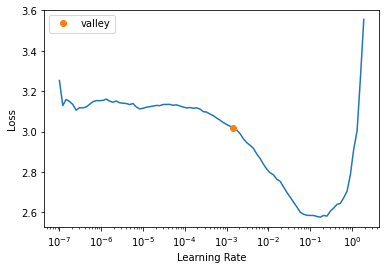

In [42]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()],
                wd=0.1, drop_mult=0.3, pretrained=True).to_fp16()
learn.lr_find()

In [43]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.596319,1.336622,0.556500,3.806166,05:29
1,1.366293,1.175974,0.613424,3.241299,05:30
2,1.238036,1.085009,0.638063,2.959466,05:27


What can be tried: perhaps cleaning set `include_newline=False`. 

Starting accuracy is better than baseline. Ending accuracy isn't too much difference (slightly worse) (mostly due to the nature of model and randomness?). Anyway, we can say this is successful cleaning. 